# Customer segmentation
+ [Online retail dataset ](http://archive.ics.uci.edu/ml/datasets/online+retail)

# Import necessary dependencies

In [5]:
import pandas as pd
import numpy as np

import datetime
import math

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score

# setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.rcParams.update(params)

# Load the dataset

In [6]:
data = pd.read_excel(io='Online Retail.xlsx')

In [7]:
data_copy = data.copy(deep=True)

# Exploratory data analysis

In [198]:
data_copy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Total:
+ InvoiceNo: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases)
+ StockCode: Identifier for items contained in an invoice.
+ Description: Textual description of each of the stock item.
+ Quantity: The quantity of the item purchased.
+ InvoiceDate: Date of purchase.
+ UnitPrice: Value of each item.
+ CustomerID: Identifier for customer making the purchase.
+ Country: Country of customer.

In [199]:
data_copy.shape

(541909, 8)

In [200]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Top sales by country

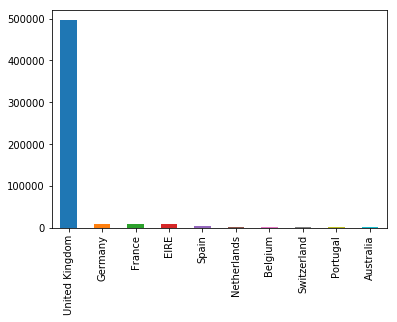

In [19]:
# data_copy.groupby('Country').size().sort_values(ascending=False)[:10].plot(kind='bar')

data_copy['Country'].value_counts()[:10].plot(kind='bar')

### Total:
+ EIRE - old name for Ireland

# Top customers contributing to 10% of sales

### Number of customers

In [23]:
data_copy['CustomerID'].unique().shape

(4373,)

In [29]:
(data_copy['CustomerID'].value_counts()/sum(data_copy['CustomerID'].value_counts())*100).cumsum().reset_index().head(13)

,index,CustomerID
0,17841.0,1.962249
1,14911.0,3.413228
2,14096.0,4.673708
3,12748.0,5.814728
4,14606.0,6.498553
5,15311.0,7.110850
6,14646.0,7.623350
7,13089.0,8.079807
8,13263.0,8.492020
9,14298.0,8.895138


### Total:
+ there are 4373 unique customers, but 10% of total buys are made by 13 customers. This is expected as there are wholesale and retail customers.

# Analyzing data quality issues

### Number of unique items

In [39]:
data_copy['StockCode'].unique().shape

(4070,)

### Number of unique descriptions


In [40]:
data_copy['Description'].unique().shape

(4224,)

### Total:
+ number of unique description is bigger than number of unique stock codes, so some items have several descriptions

### Find stock codes that have many descriptions

In [8]:
cat_des_df = data_copy.groupby(['StockCode','Description']).count().reset_index()

In [9]:
cat_des_df.head()

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,10002,INFLATABLE POLITICAL GLOBE,71,71,71,71,49,71
1,10080,GROOVY CACTUS INFLATABLE,22,22,22,22,21,22
2,10080,check,1,1,1,1,0,1
3,10120,DOGGY RUBBER,30,30,30,30,30,30
4,10125,MINI FUNKY DESIGN TAPES,94,94,94,94,64,94


In [8]:
cat_des_df['StockCode'].value_counts().reset_index().head(6)

,index,StockCode
0,20713,8
1,23084,7
2,21830,6
3,85175,6
4,23131,5
5,72807A,5


### Take a look at  descriptions of item with several descriptions

In [203]:
data_copy[data_copy['StockCode']==23343]['Description'].unique()

array(['JUMBO BAG VINTAGE CHRISTMAS ', 'came coded as 20713',
       'wrongly coded 20713', '20713 wrongly marked', 20713], dtype=object)

### Total:
+ data quality can be easily corrupted by spelling mistakes etc., which can lead to bad analysis. We will be using only attributes Quantity and UnitPrice in analysis, so it's fine for us.

### Check Quantity and UnitPrice attributes

In [204]:
data_copy['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [205]:
data_copy['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

### Total:
+ both of the attributes have negative values (return transactions). We need to handle those.

# Data cleaning

In [9]:
# separate data for one geography
data_copy = data_copy[data_copy['Country']=='United Kingdom']

# separate attribute for total amount
data_copy['amount'] = data_copy['Quantity'] * data_copy['UnitPrice'] # what about both negative Quantity and UnitPrice ?

# remove negative transactions
data_copy = data_copy[~(data_copy['amount']<0)]

# remove rows with nan CustomedID
data_copy = data_copy[data_copy['CustomerID'].notnull()]

In [207]:
data_copy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [208]:
data_copy.shape

(354345, 9)

# Feature engineering
## Create recency, frequency and monetary value features for each CustomerID

## Recency

In [10]:
# refenrence date to find the recency
reference_date = data_copy['InvoiceDate'].max() + datetime.timedelta(days=1)

In [11]:
data_copy['days_since_last_purchase'] = reference_date - data_copy['InvoiceDate']
data_copy['days_since_last_purchase_num'] = data_copy['days_since_last_purchase'].astype('timedelta64[D]')

In [12]:
customer_history_df = data_copy.groupby('CustomerID').min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)
customer_history_df.recency.describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

## Distribution of customer recency

Text(0.5,1,'$\\mathrm{Histogram\\ of\\ sales\\ recency}\\ $')

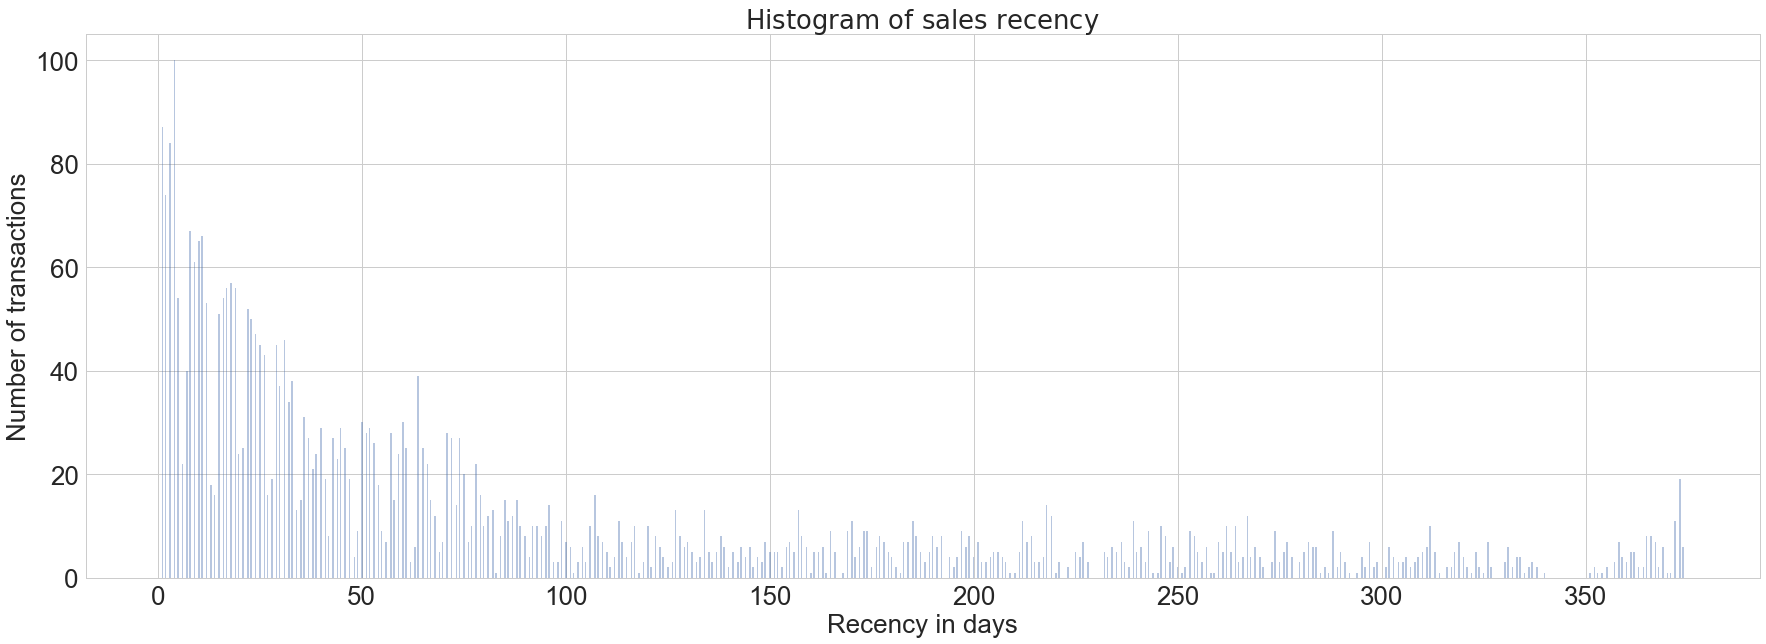

In [212]:
fig, ax = plt.subplots()
sns.distplot(customer_history_df.recency,bins=1000,ax=ax, kde=False)
ax.set_xlabel('Recency in days')
ax.set_ylabel('Number of transactions')
ax.set_title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')

### Total:
+ plot tells us that we have a skewed distribution of sales recency. More transactions were made recently.

## Frequency and monetary value

In [13]:
customer_monetary_value = data_copy[['CustomerID','amount']].groupby('CustomerID').sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_value,how='outer')
customer_history_df.amount = customer_history_df.amount + 0.001
customer_frequency = data_copy[['CustomerID','amount']].groupby('CustomerID').count().reset_index()
customer_frequency.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_frequency,how='outer')

+ amount was increased by 0.001 to avoid having zeros during future log transforms

In [214]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


## Distribution plots for monetary value and frequency attributes

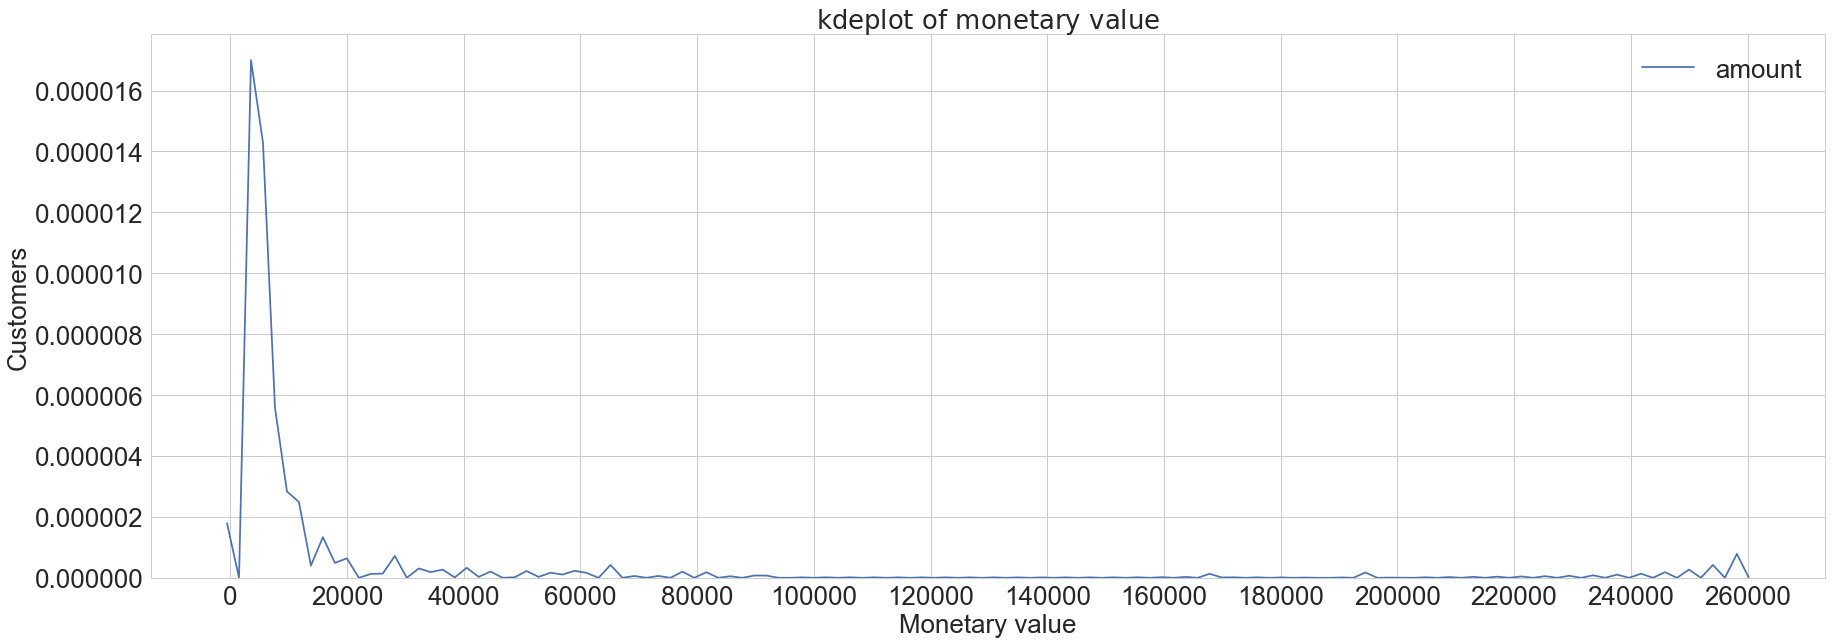

In [28]:
fig, ax = plt.subplots()
sns.kdeplot(customer_history_df.amount,ax=ax)
ax.set_xlabel('Monetary value')
ax.set_ylabel('Customers')
ax.set_title(r'$\mathrm{kdeplot\ of\ monetary \ value}\ $')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20000))

### Total:
+ plot tells us that we have a skewed distribution. The most monetary values lie in range [0,20000]

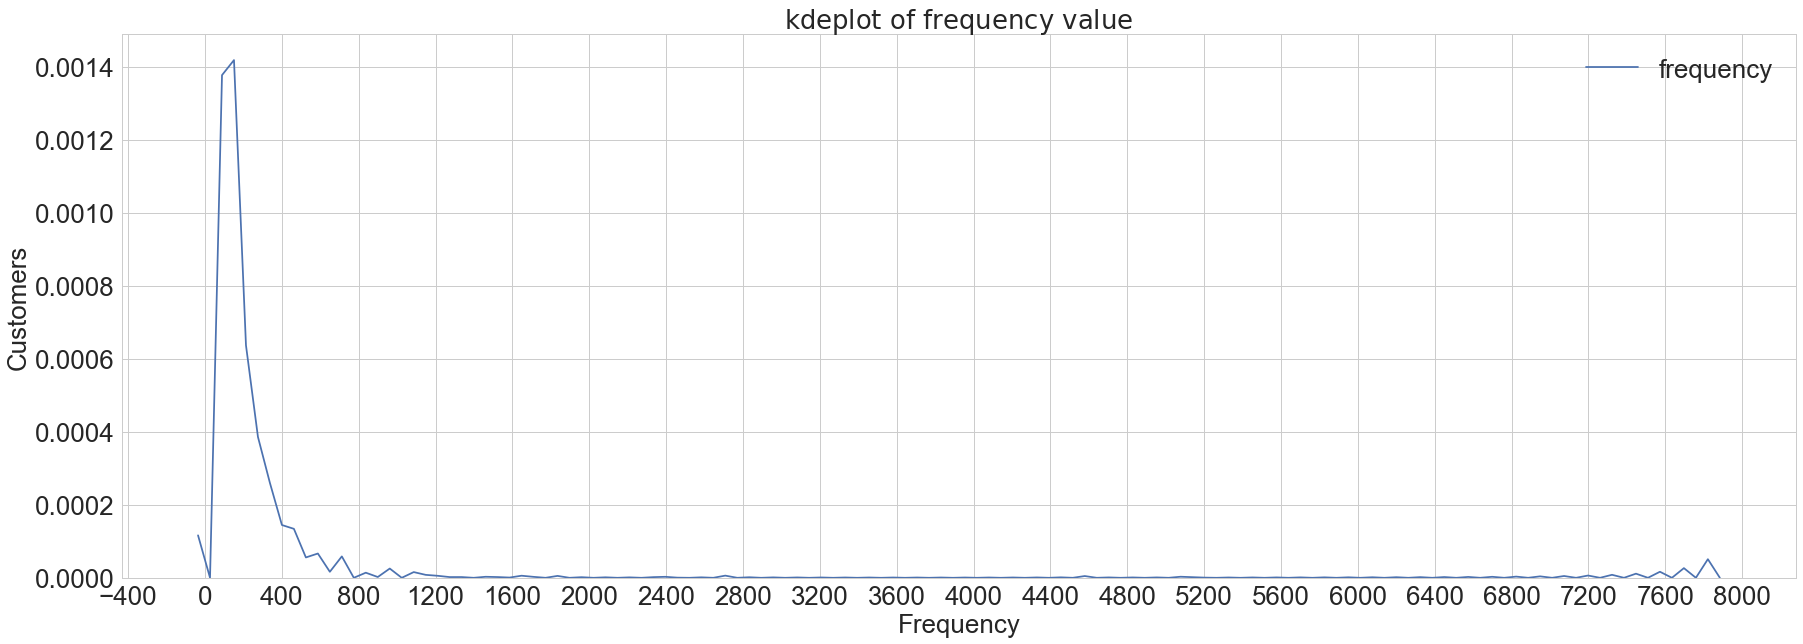

In [239]:
fig, ax = plt.subplots()
sns.kdeplot(customer_history_df.frequency,ax=ax)
ax.set_xlabel('Frequency')
ax.set_ylabel('Customers')
ax.set_title(r'$\mathrm{kdeplot\ of\ frequency \ value}\ $')
ax.xaxis.set_major_locator(ticker.MultipleLocator(400))

### Total:
+ plot tells us that we have a skewed distribution. The most frequencies lie in range [0,400]

# Data preprocessing

### For k-means clustering algorithm we need to:
+ log-transform our data to make values be in the same range
+ standardize the data

In [14]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)

selected_features = ['recency_log','amount_log','frequency_log']

X_subset = customer_history_df[selected_features].values
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

## Visualize monetary value distribution after preprocessing

Text(0.5,1,'$\\mathrm{Histogram\\ of\\ transformed \\ monetary \\ value}\\ $')

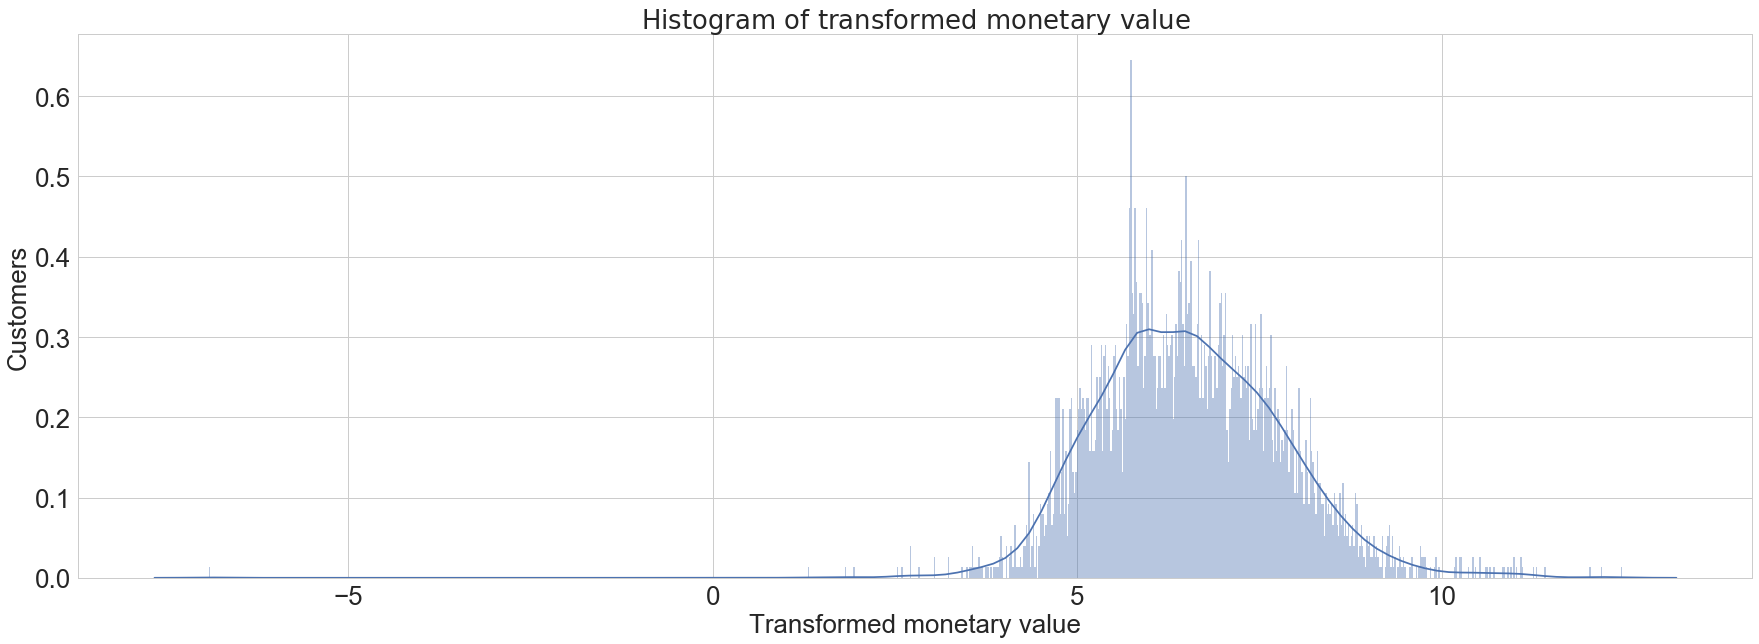

In [254]:
fig, ax = plt.subplots()
sns.distplot(customer_history_df.amount_log,ax=ax,bins=1000)
ax.set_xlabel('Transformed monetary value')
ax.set_ylabel('Customers')
ax.set_title(r'$\mathrm{Histogram\ of\ transformed \ monetary \ value}\ $')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(20000))

### Total:
+ graph resembles normal distribution with mean 0 and variance of 1

## Three-dimensional plot

Text(0.5,0.92,'Scatter plot of RFM')

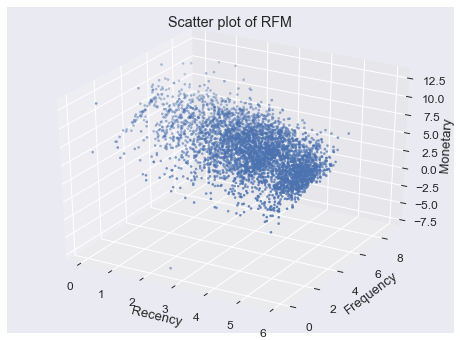

In [263]:
from mpl_toolkits.mplot3d import Axes3D
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Scatter plot of RFM')

### Total:
+  people who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary value
+ people who buy more recently have higher monetary values, increasing with frequency

# K-means clustering

In [15]:
def silhouette(n_clusters, data, feature1, feature2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #     fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :",
          silhouette_avg)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd plot
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data[:, feature1],
        data[:, feature2],
        marker='.',
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, feature1],
        centers[:, feature2],
        marker='o',
        c="white",
        alpha=1,
        s=200,
        edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(
            c[feature1],
            c[feature2],
            marker='$%d$' % i,
            alpha=1,
            s=50,
            edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the feature#{}".format(feature1))
    ax2.set_ylabel("Feature space for the feature#{}".format(feature2))

    plt.suptitle(
        ("Silhouette analysis for KMeans clustering on sample data "
         "with n_clusters = %d" % n_clusters),
        fontsize=14,
        fontweight='bold')
    return clusterer.cluster_centers_,silhouette_avg,cluster_labels

## Visualize clustering with different number of clusters

In [16]:
range_n_clusters = [2,3,5]

For n_clusters = 2 The average silhouette_score is : 0.3947793031805252
For n_clusters = 3 The average silhouette_score is : 0.30437444714898737
For n_clusters = 5 The average silhouette_score is : 0.27958641427323727


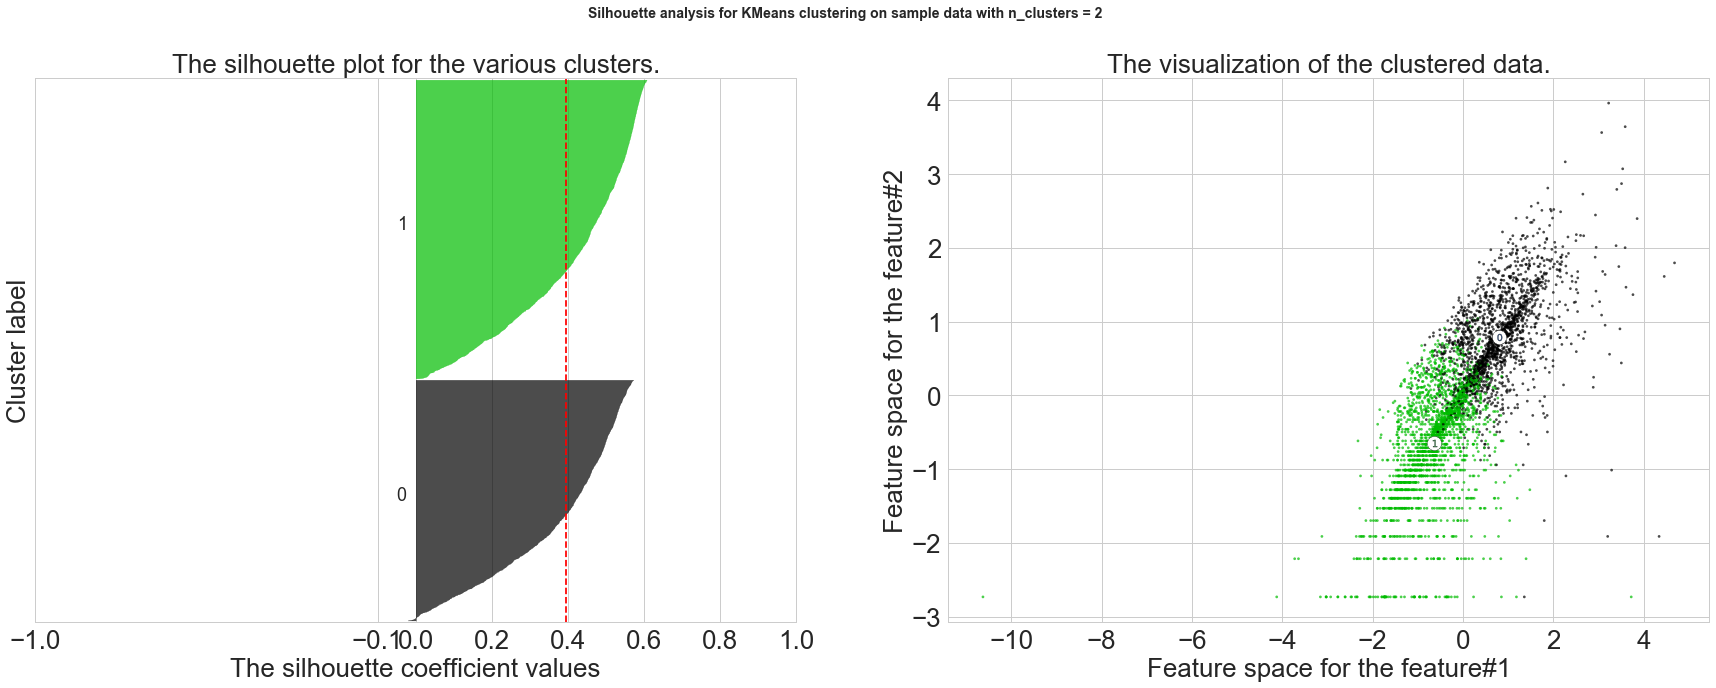

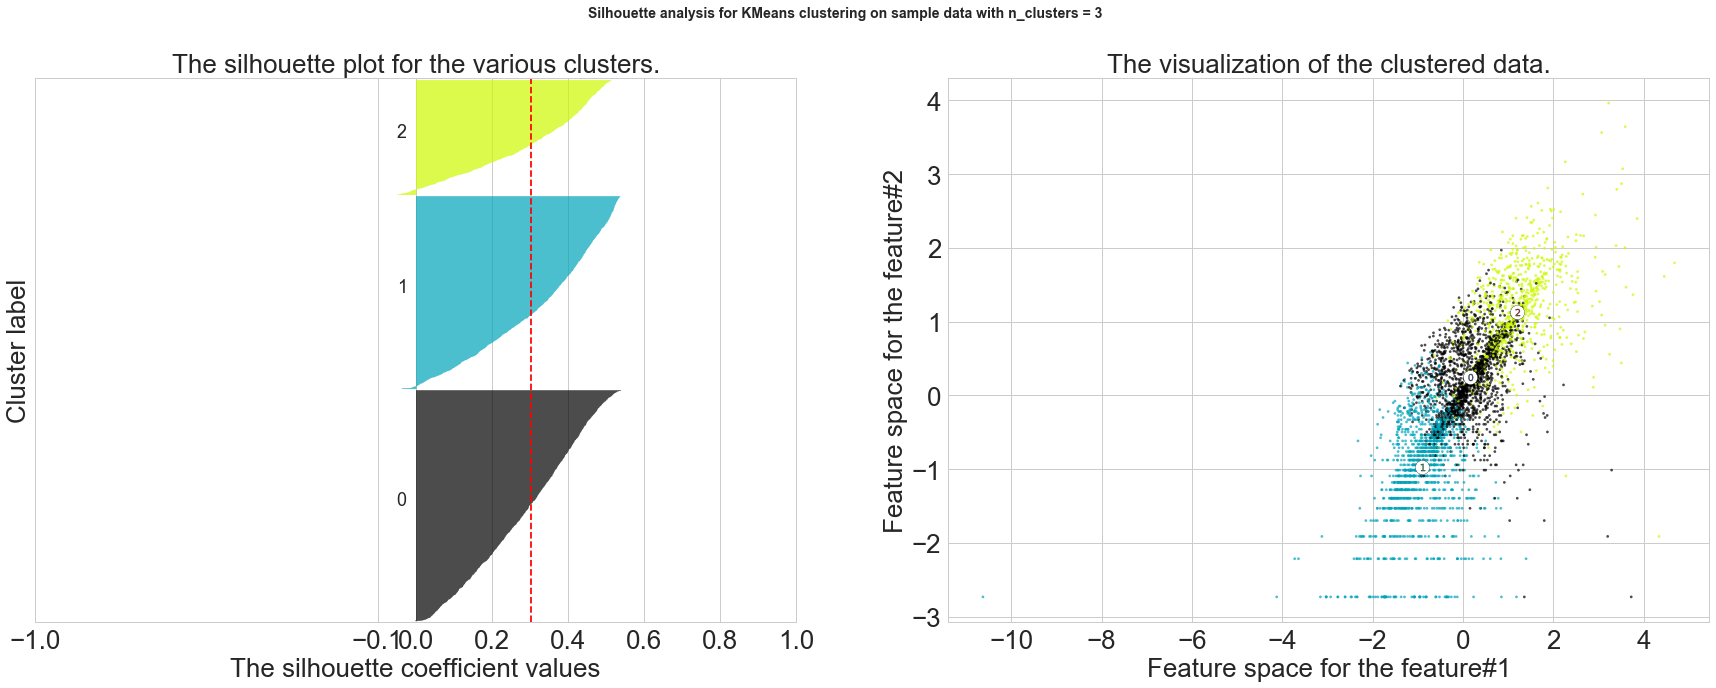

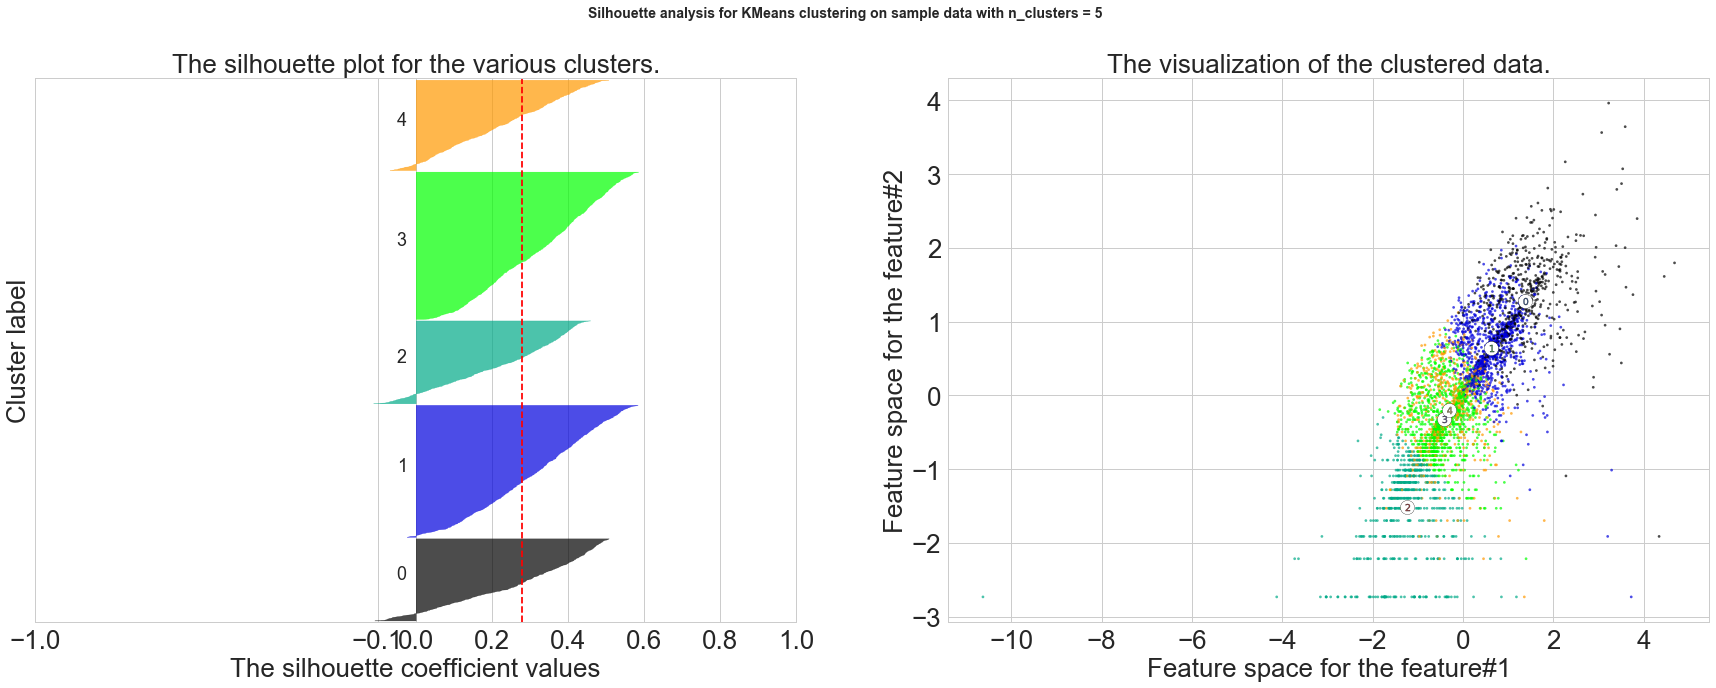

In [17]:
cluster_centers = dict()
for n_clusters in range_n_clusters:
    centers_, s_avg_, cluster_labels = silhouette(
        n_clusters, X_scaled, 1,
        2)  # features selected: monetary value and frequency
    cluster_centers.update({
        n_clusters: {
            'cluster_center': centers_,
            'silhouette_score': s_avg_,
            'labels': cluster_labels
        }
    })

# Cluster analysis

In [83]:
for i in range_n_clusters:
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=selected_features))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 2 number of clusters
   recency_log   amount_log  frequency_log
0    15.979529  1882.387664     113.171740
1    96.013791   308.723197      16.442814
Silhouette score for cluster 2 is 0.3947793031805252

for 3 number of clusters
   recency_log   amount_log  frequency_log
0    44.083222   843.937271      53.920633
1   121.766072   221.236034      10.668661
2     7.196647  3159.294272     177.789098
Silhouette score for cluster 3 is 0.30437444714898737

for 5 number of clusters
   recency_log   amount_log  frequency_log
0     5.627973  3905.544371     214.465989
1    46.880212  1502.519606      92.306262
2   126.546751   142.867249       5.147370
3   139.056216   408.235418      25.530424
4    13.386419   464.371885      29.581298
Silhouette score for cluster 5 is 0.27958641427323727



### 2 clusters total:
+ we get 2 groups: high amount - 0, low amount - 1. High amount is very important for business.
+ there is a correlation high amount + low recency + high frequency

### 3 clusters total:
+ we get 3 groups: very high amount - 2, medium amount - 0, low amount - 1. High amount is very important for business.
+ there is a correlation high amount + low recency + high frequency

### 5 clusters total:
+ very hight amount from 3 clusters was divided into two groups: those with very high amount and low frequency and those with lower amount and lower frequency
+ medium group from 3 clusters was also divided into two groups that have comparable amounts and frequencies but differ in high recency and low recency 

### Total:
+ 5-clusters give better insights into customer segmentation than 3 clusters, although 5-clusters have lower average silhouette score
+ if we look at the plots of clusters we can see that 5-clusters have many overlaps, which is not very good, whereas 3-clusters have less overlaps

# Cluster descriptions

## Assign cluster labels

In [18]:
customer_history_df_copy = customer_history_df
customer_history_df_copy['cluster5_labels'] = cluster_centers[5]['labels']
customer_history_df_copy['cluster3_labels'] = cluster_centers[3]['labels']
customer_history_df_copy['cluster2_labels'] = cluster_centers[2]['labels']

In [86]:
customer_history_df_copy.head()

,CustomerID,recency,amount,frequency,recency_log,amount_log,frequency_log,cluster5_labels,cluster3_labels,cluster2_labels
0,12346.0,326.0,77183.601,1,5.786897,11.253942,0.000000,1,0,1
1,12747.0,2.0,4196.011,103,0.693147,8.341890,4.634729,0,2,0
2,12748.0,1.0,33719.731,4596,0.000000,10.425838,8.432942,0,2,0
3,12749.0,4.0,4090.881,199,1.386294,8.316516,5.293305,0,2,0
4,12820.0,3.0,942.341,59,1.098612,6.848367,4.077537,4,2,0


## Visualize segments

In [74]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)


def rand_rgba():
    return 'rgba(' + str(np.random.uniform(low=0., high=255.)) + ',' + str(
        np.random.uniform(low=0., high=255.)) + ',' + str(
            np.random.uniform(low=0., high=255.)) + ',' + str(
                np.random.uniform(low=0., high=255.)) + ')'


def plotly_boxplot_segments(segments, quantile, df, field_to_plot,
                            field_with_labels):
    x_data = ['Cluster ' + str(i) for i in range(segments)]
    y_data = []
    for i in range(segments):
        curr_y = df[df[field_with_labels] == i][field_to_plot].values
        curr_y = curr_y[curr_y < np.percentile(curr_y, quantile)]
        y_data.append(curr_y)
    colors = [rand_rgba() for i in range(segments)]
    traces = []

    for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(
            go.Box(
                y=yd,
                name=xd,
                boxpoints=False,
                jitter=0.5,
                whiskerwidth=0.2,
                fillcolor=cls,
                marker=dict(size=2, ),
                line=dict(width=1),
            ))

    layout = go.Layout(
        title='Difference in sales {} from cluster to cluster'.format(
            field_to_plot),
        yaxis=dict(
            autorange=True,
            showgrid=True,
            zeroline=True,
            dtick=500,
            gridcolor='black',
            gridwidth=0.1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,
        ),
        margin=dict(
            l=40,
            r=30,
            b=80,
            t=100,
        ),
        paper_bgcolor='white',
        plot_bgcolor='white',
        showlegend=False)

    fig = go.Figure(data=traces, layout=layout)
    py.offline.iplot(fig)


def seaborn_boxplot_segments(df, to_plot, labels_field, quantile):
    sns.boxplot(
        data=df[df[to_plot] < np.percentile(df[to_plot].values, quantile)],
        x=labels_field,
        y=to_plot)

In [75]:
plotly_boxplot_segments(5,80,customer_history_df_copy,'amount','cluster5_labels')

# 5-clusters

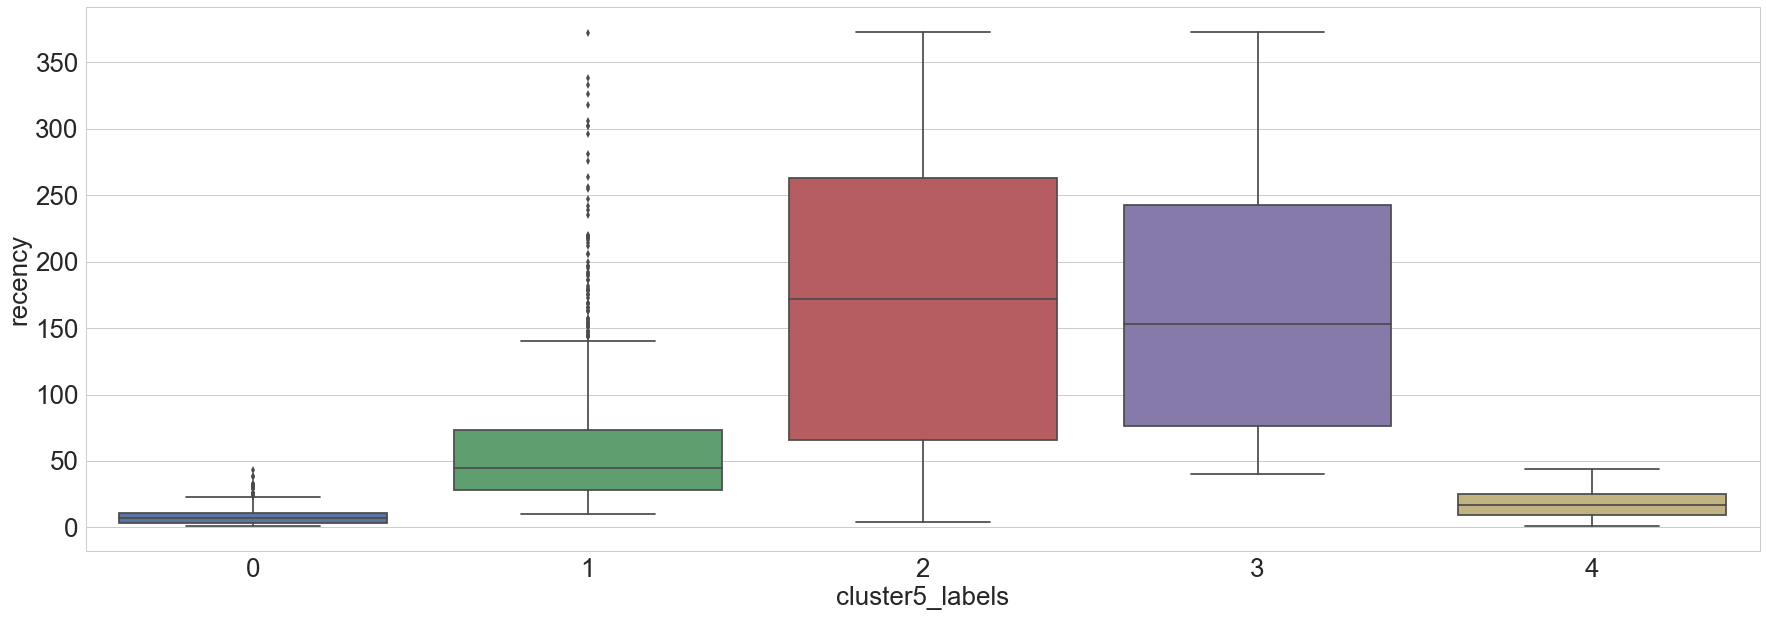

In [114]:
seaborn_boxplot_segments(customer_history_df_copy,'recency','cluster5_labels',100)

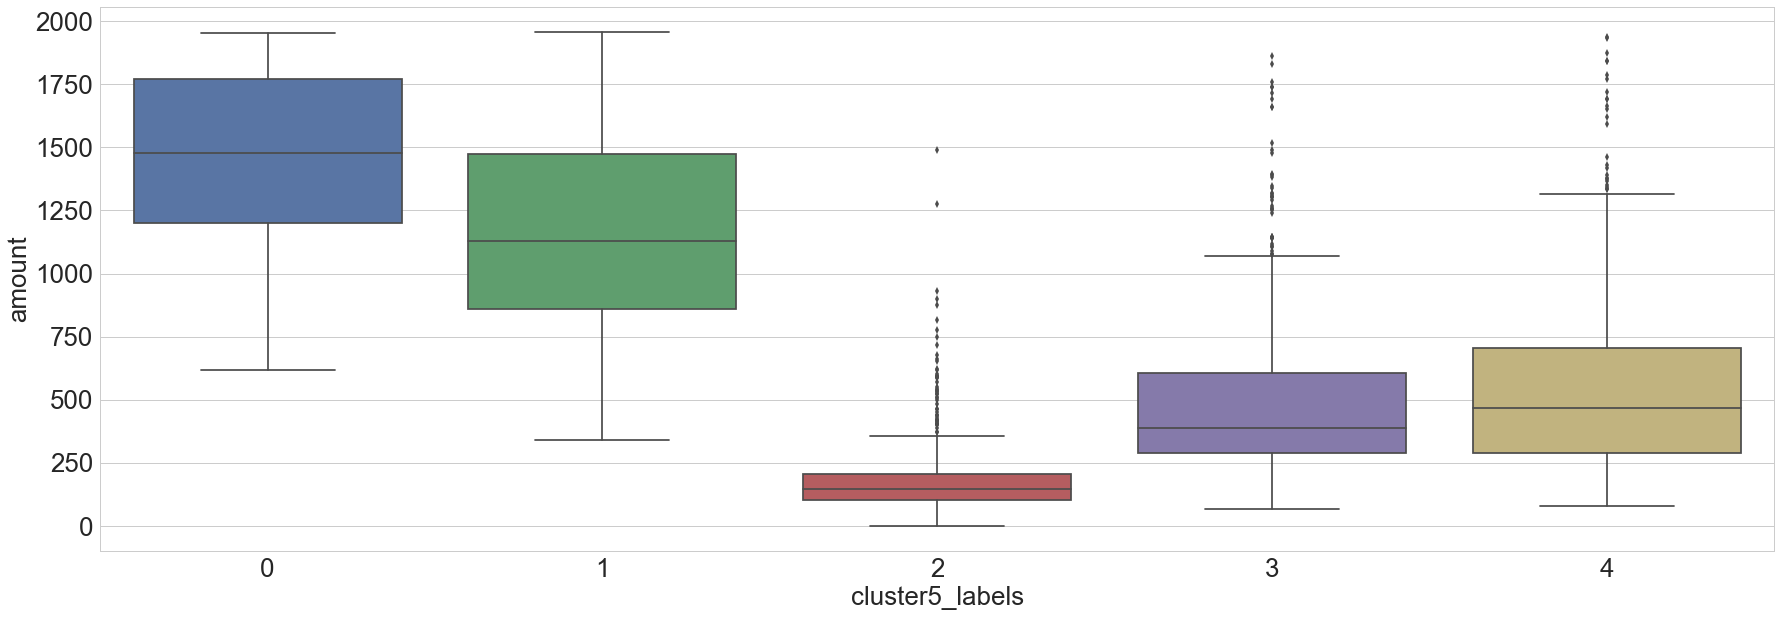

In [115]:
seaborn_boxplot_segments(customer_history_df_copy,'amount','cluster5_labels',80)

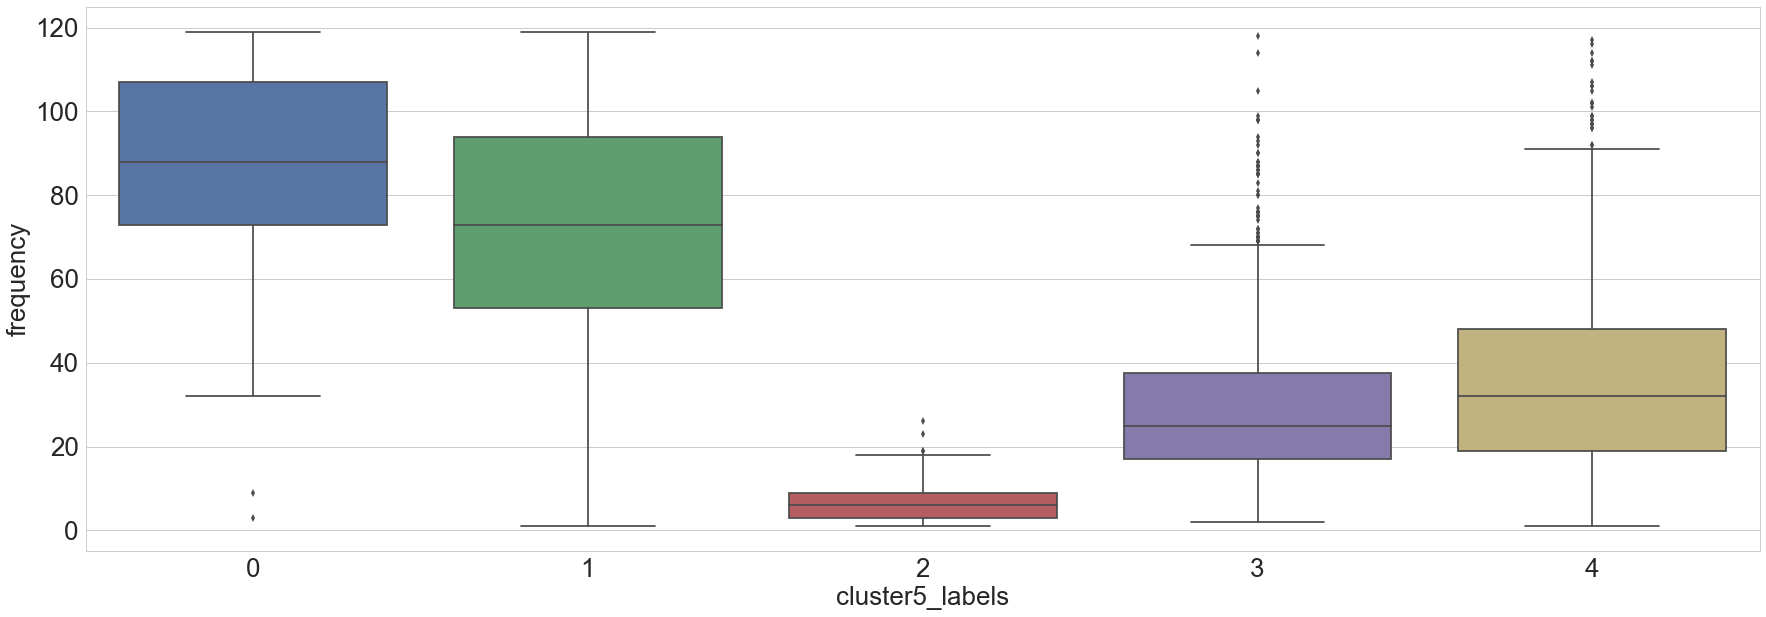

In [116]:
seaborn_boxplot_segments(customer_history_df_copy,'frequency','cluster5_labels',80)

## Total:
+ it is possible to merge some clusters based on different features (such as merge 0 and 1 based on amount)

# 3-clusters

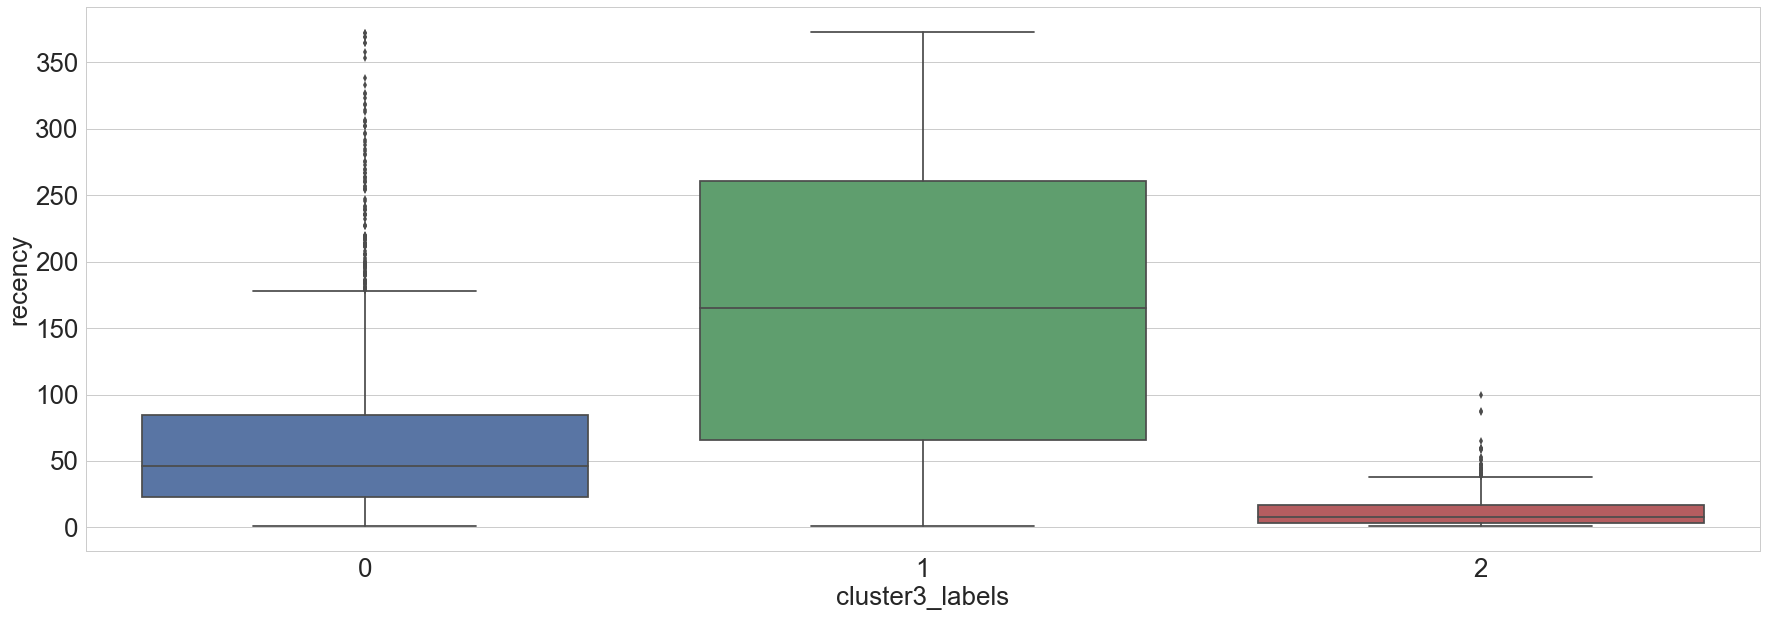

In [120]:
seaborn_boxplot_segments(customer_history_df_copy,'recency','cluster3_labels',100)

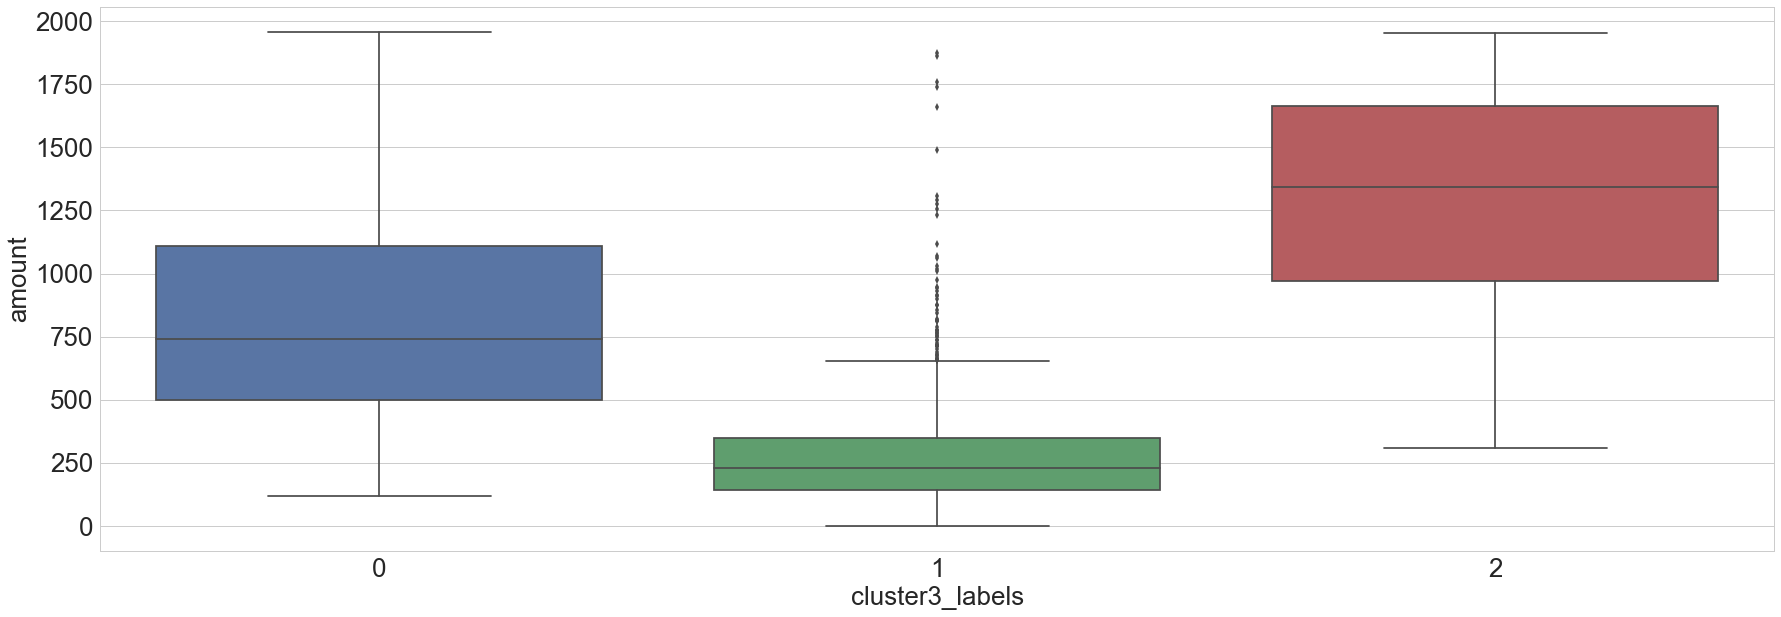

In [121]:
seaborn_boxplot_segments(customer_history_df_copy,'amount','cluster3_labels',80)

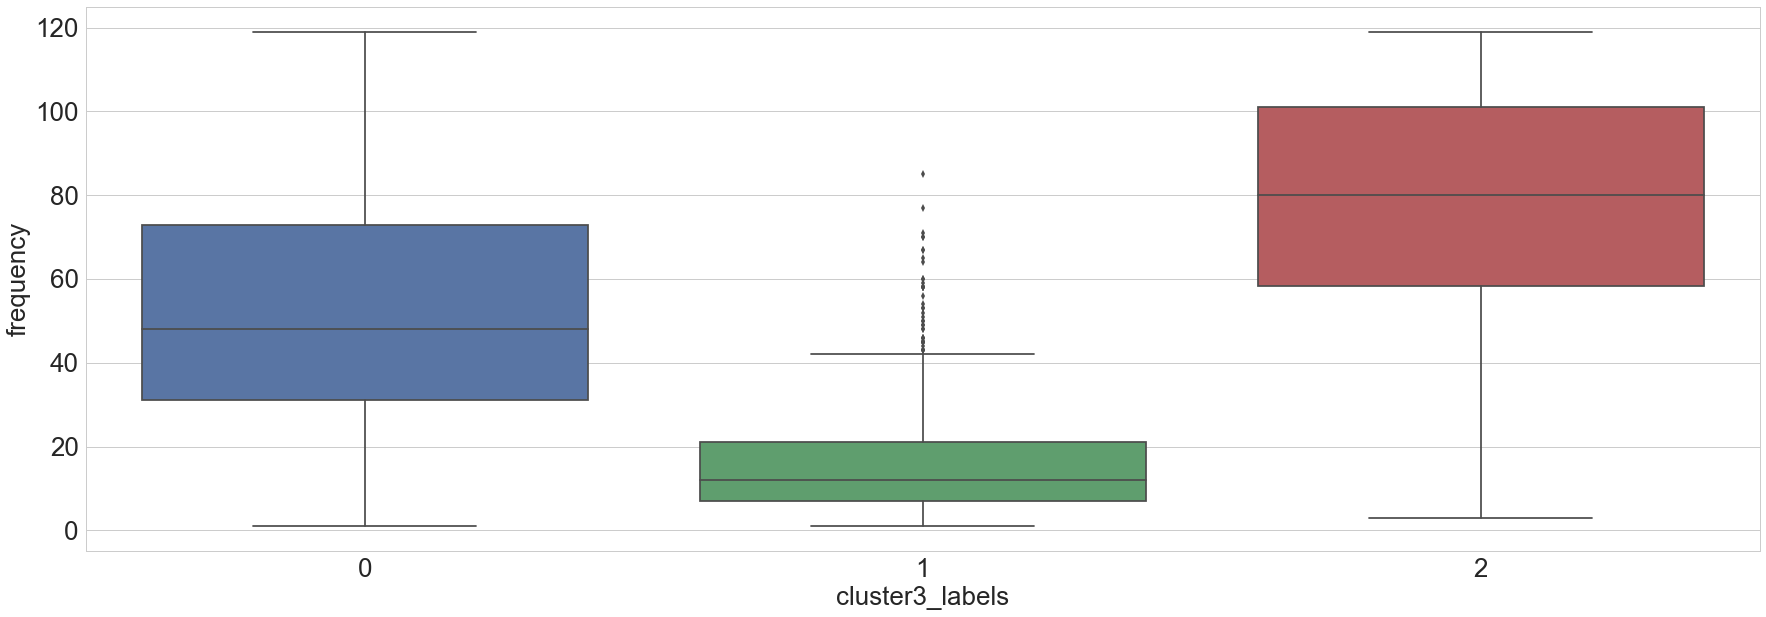

In [81]:
seaborn_boxplot_segments(customer_history_df_copy,'frequency','cluster3_labels',80)

# 2-clusters

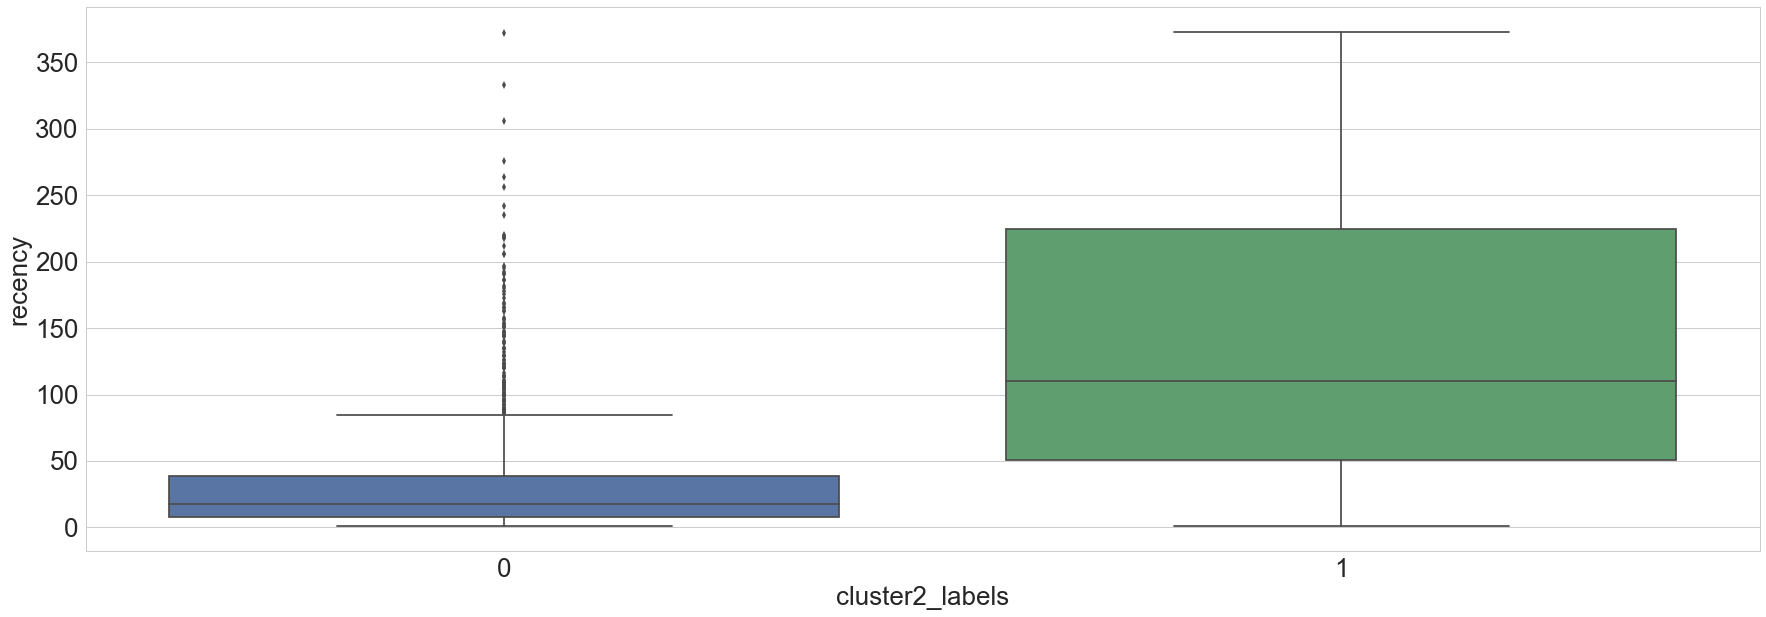

In [77]:
seaborn_boxplot_segments(customer_history_df_copy,'recency','cluster2_labels',100)

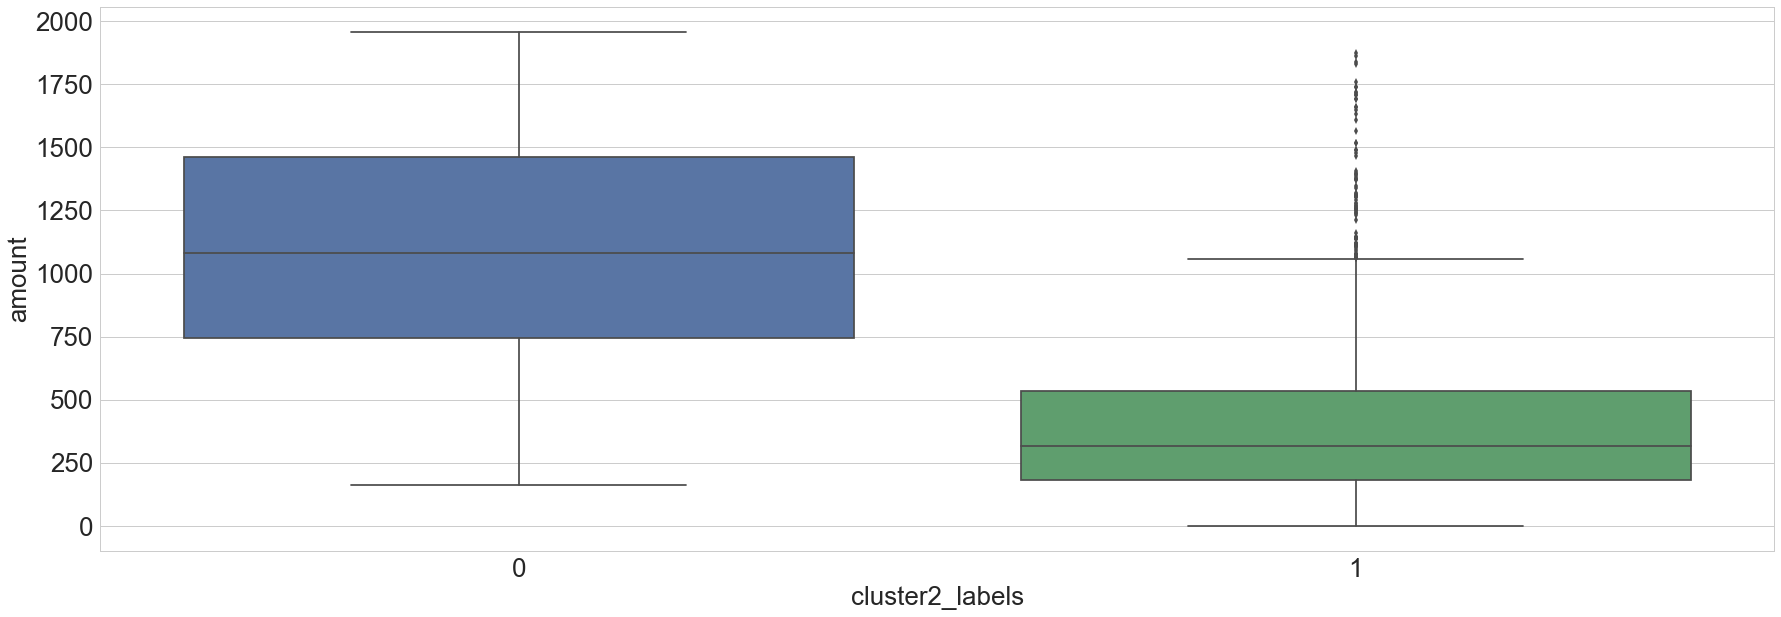

In [78]:
seaborn_boxplot_segments(customer_history_df_copy,'amount','cluster2_labels',80)

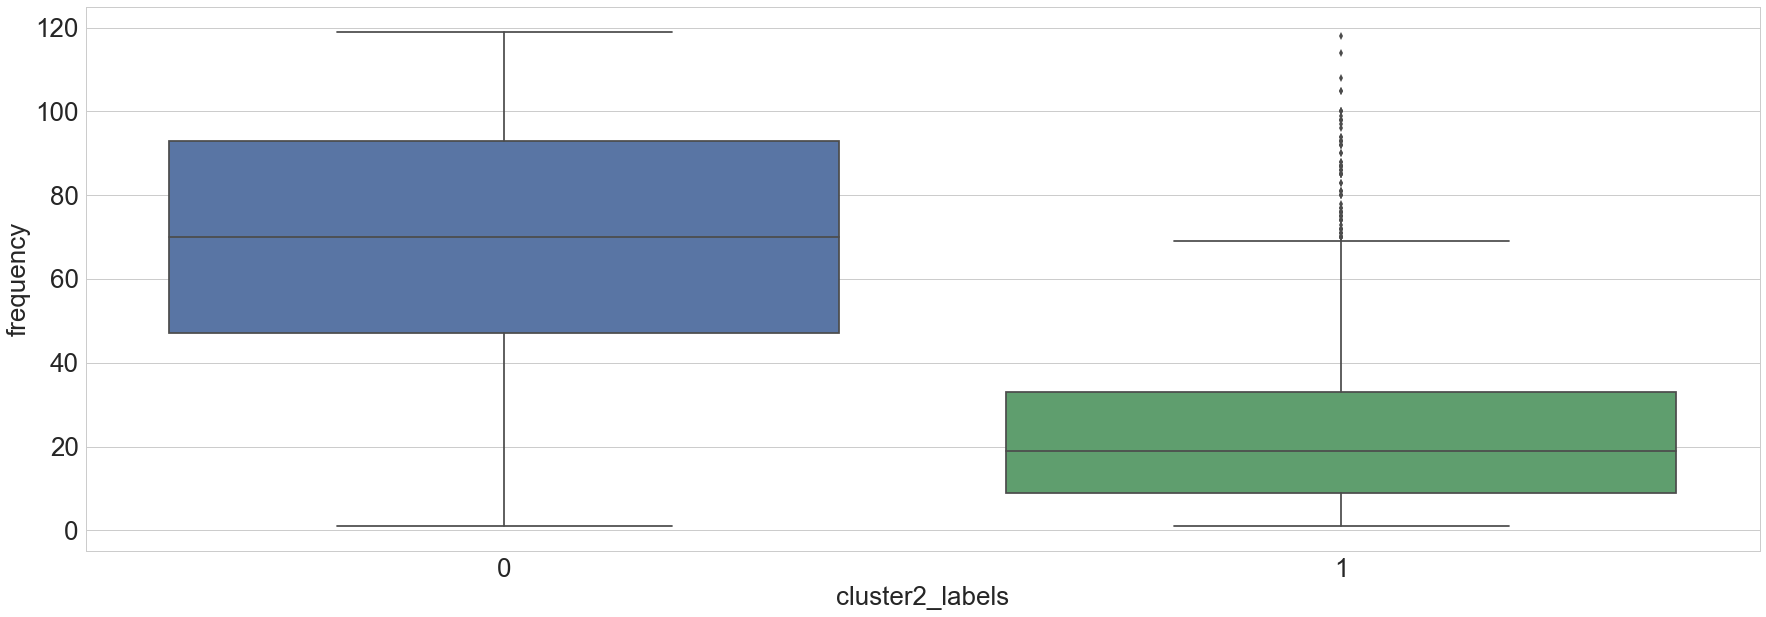

In [80]:
seaborn_boxplot_segments(customer_history_df_copy,'frequency','cluster2_labels',80)

## Total:
+ 3-clusters show better distinctivness between clusters
+ 3-clusters show less overlap between values than 5-clusters
+ previous points don't mean that 5-clusters is bad, it's just another point of view

# Possible improvements:
+ get better data with multiple years of transactional data
+ choose different clustering algorithm (hierarchical etc.)
+ engineer other important features

# Do not to forget:
+ use business metrics to make decisions and not only mathematical